In [3]:
import string
import warnings
from sklearn.model_selection import train_test_split
import torch

import pandas as pd
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from tqdm import tqdm

warnings.filterwarnings('ignore')

stopwords = stopwords.words('italian')

filename = 'modenaToday'

def get_datasets(filename: str) -> (pd.DataFrame, pd.DataFrame):
    """
    Load and split datasets based on the filename provided.
    
    :param filename: str - Name of the dataset to load and split.
    :return: Tuple containing training and testing dataframes (pd.DataFrame, pd.DataFrame).
    """
    df_train, df_test = None, None
    if filename == 'manualDICE':
        dataset = pd.read_csv('./datasets/manualDICE/manualDICE.csv')
        df_train, df_test = train_test_split(dataset, test_size=0.2, shuffle=True)
    elif filename == 'modenaToday':
        dataset = pd.read_csv('./datasets/modenaToday/modenatoday.csv')
        df_train, df_test = train_test_split(dataset, test_size=0.2, shuffle=True)
    elif filename == 'RCV':
        df_train = pd.read_csv('./datasets/RCV/RCV-it_train.csv')
        df_test = pd.read_csv('./datasets/RCV/RCV-it_test.csv')

    return df_train, df_test


df_train, df_test = get_datasets(filename)


def preprocess_text(text: str) -> str:
    """
    Preprocess a given text by converting to lowercase, removing punctuation and numbers, tokenizing,
    removing stopwords and short words.
    
    :param text: str - Text to preprocess.
    :return: str - Processed text as a string of words.
    """
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopwords and len(word) > 2]
    processed_text = ' '.join(filtered_tokens)
    return processed_text


def build_graph(text: str, label: int, word_vectors: KeyedVectors) -> Data:
    """
    Build a graph from text data using provided word vectors. Nodes represent words and edges represent 
    proximity in the text within a window.
    
    :param text: str - Text to convert into a graph.
    :param label: int - Label for the graph.
    :param word_vectors: KeyedVectors - Pre-trained word vectors.
    :return: Data - Graph data object.
    """
    edges = []
    node_features = []
    word_indices = {}
    current_index = 0
    text = text.split()

    for word in text:
        if word in word_vectors:
            node_features.append(word_vectors[word])
            if word not in word_indices:
                word_indices[word] = current_index
                current_index += 1

    for i, word in enumerate(text):
        if word in word_vectors:
            for j in range(max(0, i - 4), min(len(text), i + 4)):
                if i != j and text[j] in word_vectors:
                    edges.append((word_indices[word], word_indices[text[j]]))

    if len(edges) == 0:
        edges = [(0, 0)]

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


print('Endoding labels...')
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])

print('Loading wikipedia2vec embeddings...')
word_vectors = KeyedVectors.load_word2vec_format('./wikipedia2vec/itwiki_20180420_100d.txt', binary=False)

tqdm.pandas(desc='Processing text train:')
df_train['text'] = df_train['text'].progress_apply(preprocess_text)

tqdm.pandas(desc='Processing text test:')
df_test['text'] = df_test['text'].progress_apply(preprocess_text)

train_graphs = [build_graph(row['text'], row['label'], word_vectors) for _, row in
                tqdm(df_train.iterrows(), total=len(df_train), desc="Building training graphs:")]

test_graphs = [build_graph(row['text'], row['label'], word_vectors) for _, row in
               tqdm(df_test.iterrows(), total=len(df_test), desc="Building test graphs")]

OUTPUT_DIM = len(set(df_train['label']))
INPUT_DIM = word_vectors.vector_size
HIDDEN_DIM = 64


Endoding labels...
Loading wikipedia2vec embeddings...


Building test graphs: 100%|██████████| 1102/1102 [00:01<00:00, 659.06it/s]


In [4]:
import torch
from torch.nn import Dropout
from torch_geometric.nn import GCNConv, global_max_pool
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """
        Initialize the Graph Convolutional Network (GCN) model.

        :param input_dim: int - Number of input features.
        :param hidden_dim: int - Number of hidden units.
        :param output_dim: int - Number of output features, typically the number of classes.
        """
        super(GCN, self).__init__()
        # First graph convolutional layer
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Second graph convolutional layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # Fully connected layer for output
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        # Dropout layer to prevent overfitting
        self.dropout = Dropout(p=0.5)

    def forward(self, data: Data) -> torch.Tensor:
        """
        Forward pass of the model. Processes the input data through two convolutional layers,
        applies ReLU activation, pools graph nodes globally, applies dropout, and passes
        through a fully connected layer to produce the output.

        :param data: Data - Input graph data containing nodes, edges, and batch information.
        :return: torch.Tensor containing class logits.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Apply first graph convolutional layer and ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Apply second graph convolutional layer and ReLU activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Apply global max pooling across nodes in a batch
        x = global_max_pool(x, batch)
        # Apply dropout
        x = self.dropout(x)
        # Apply final fully connected layer
        x = self.fc(x)
        return x


Using device: cpu
Training model...
Epoch: 1, Train Accuracy: 66.88%, Validation Accuracy: 67.35%
Best updated!
Epoch: 2, Train Accuracy: 70.31%, Validation Accuracy: 70.98%
Best updated!
Epoch: 3, Train Accuracy: 75.12%, Validation Accuracy: 74.15%
Best updated!
Epoch: 4, Train Accuracy: 78.47%, Validation Accuracy: 78.23%
Best updated!
Epoch: 5, Train Accuracy: 79.61%, Validation Accuracy: 78.00%
Epoch: 6, Train Accuracy: 82.88%, Validation Accuracy: 79.14%
Best updated!
Epoch: 7, Train Accuracy: 81.85%, Validation Accuracy: 81.41%
Best updated!
Epoch: 8, Train Accuracy: 81.93%, Validation Accuracy: 78.91%
Epoch: 9, Train Accuracy: 82.58%, Validation Accuracy: 79.37%
Epoch: 10, Train Accuracy: 85.35%, Validation Accuracy: 82.77%
Best updated!
Epoch: 11, Train Accuracy: 86.29%, Validation Accuracy: 82.31%
Epoch: 12, Train Accuracy: 86.89%, Validation Accuracy: 81.86%
Epoch: 13, Train Accuracy: 85.48%, Validation Accuracy: 81.86%
Epoch: 14, Train Accuracy: 83.14%, Validation Accuracy: 

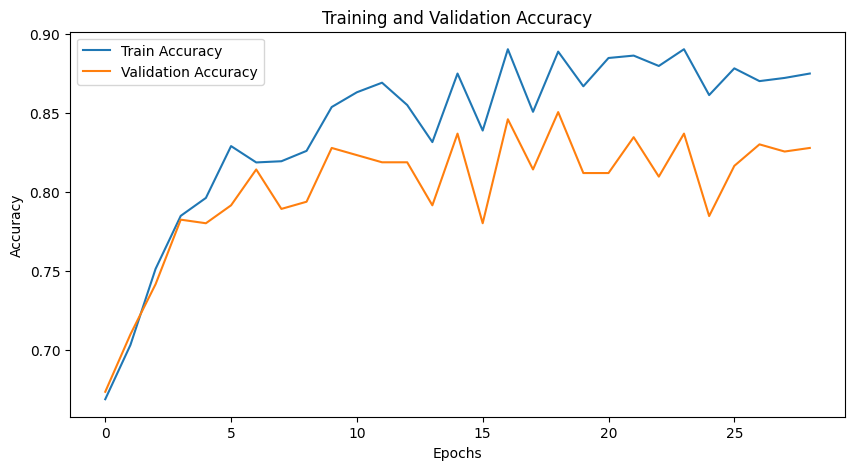

In [5]:
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

train_graphs, validation_graphs = train_test_split(train_graphs, test_size=0.1)

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_graphs, batch_size=16, shuffle=False)

model = GCN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_val_acc = 0.0
epochs_without_improvement = 0
patience = 10

def train() -> float:
    """
    Train the model for one epoch.

    :return: float - The average loss over the training data.
    """
    model.train()
    total_loss = 0
    processed_batches = 0

    for data in train_loader:
        data = data.to(device)
        output = model(data)

        if output.size(0) != data.y.size(0):
            continue

        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        processed_batches += 1

    average_loss = total_loss / processed_batches if processed_batches > 0 else 0
    return average_loss


@torch.no_grad()
def test(loader: DataLoader) -> float:
    """
    Evaluate the model on the given data loader.

    :param loader: DataLoader - The data loader for the dataset to test.
    :return: float - The accuracy of the model on the dataset.
    """
    model.eval()
    correct = 0
    total_processed = 0

    for data in loader:
        data = data.to(device)
        output = model(data)

        # Skip the batch if the dimensions of output and labels do not match
        if output.size(0) != data.y.size(0):
            continue

        pred = output.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total_processed += data.y.size(0)

    accuracy = correct / total_processed if total_processed > 0 else 0
    return accuracy


train_accuracies = []
val_accuracies = []

print('Training model...')
for epoch in range(200):
    train()
    train_acc = test(train_loader)
    val_acc = test(validation_loader)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch + 1}, Train Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        print('Best updated!')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Stop training after {epoch + 1} epochs due to no improvement in validation accuracy')
        break

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [6]:
test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)
acc = test(test_loader)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 83.58%
